In [31]:
from scipy import ndimage
from scipy.signal import convolve2d
import numpy as np
from osgeo import gdal

def four_neighbor_average_convolve2d(array, no_data_value = -9999.0):
    is_valid = (array != no_data_value) & (~np.isnan(array))
    mask = is_valid.astype(float)

    kernel = np.array( [[0,1,0],
                        [1,0,1],
                        [0,1,0]])

    array_clean = np.where(is_valid, array, 0.0)
    neighbor_sum = convolve2d(
        array_clean, kernel, mode='same',
        boundary='fill', fillvalue=0)

    num_neighbor = convolve2d(
        mask, kernel, mode='same', 
        boundary='fill', fillvalue=0)
    
    avg = np.divide(neighbor_sum, num_neighbor, 
                    out=np.full_like(array, np.nan, dtype=float), 
                    where=num_neighbor > 0)

    return np.where(is_valid, avg, np.nan)

ds = gdal.Open('/home/richmond/Downloads/test_clipped.tif')
array = ds.GetRasterBand(1).ReadAsArray(0)

# array = np.array(
#     [[-9999,-9999,-9999,-9999],
#     [-9999,211,200,-9999],
#     [-9999,32134,3456,34],
#     [-9999,-9999,-9999,-9999]]
# )

# x = four_neighbor_average_convolve2d(array)
# x

In [41]:
# Create a copy of the array
prev_dem = array.copy()
iter = 0
tol = 0.001
current_tol = 1000

vol_list = []
tol_list = []


while iter < 100000 and current_tol > tol:
    # Convolve2d
    mat_neigh = four_neighbor_average_convolve2d(prev_dem)

    # Compare the two arrays, and get just the minimum
    mat_comp = np.fmin(prev_dem, mat_neigh)

    # Subtract: prev_dem - mat_comp
    mat_diff = np.where(np.isnan(prev_dem), np.nan, mat_comp - prev_dem)

    # Get max of mat_diff for tolerance checking
    current_tol = np.max(np.abs(mat_diff))

    # Convert mat_comp -> prev_dem
    prev_dem = mat_comp.copy()

    x = array.copy()
    x[(x == -9999)] = np.nan
    array_nan = x
    volume = np.nansum(np.subtract(x, prev_dem))

    vol_list.append(volume)
    tol_list.append(current_tol)
    iter+=1

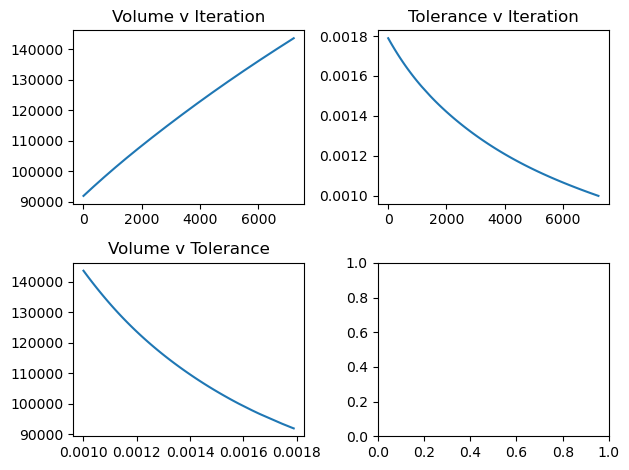

In [59]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(2,2)

ax[0,0].plot(
    vol_list[4999:],
)

ax[0,1].plot(
    tol_list[4999:],
)

ax[1,0].plot(
    tol_list[4999:],
    vol_list[4999:],
    
)

ax[0,0].set_title("Volume v Iteration")
ax[0,1].set_title("Tolerance v Iteration")
ax[1,0].set_title('Volume v Tolerance')
fig.tight_layout()

plt.show()